In [1]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import metrics

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
path = 'C:/Users/duran/Downloads/CheXpert-v1.0-small/CheXpert-v1.0-small'
dtrain=pd.read_csv(path + "/train.csv")
dtrain = dtrain.fillna(0)

dnew=pd.read_csv(path + "/valid.csv")
dnew = dnew.fillna(0)

In [4]:
dtrain['Path'] = 'C:/Users/duran/Downloads/CheXpert-v1.0-small/' + dtrain['Path'].astype(str)
dnew['Path'] = 'C:/Users/duran/Downloads/CheXpert-v1.0-small/' + dnew['Path'].astype(str)

In [5]:
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)

print(dtrain.shape)
dtrain.describe().transpose()

dtrain = dtrain.replace(-1,0)

(191027, 15)


In [6]:
features_size=[]
features_data =[]
features_name=[]
for feature in list(dtrain.columns[1:15]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)
    
print(dtrain.shape)
print(list(dtrain.columns[1:15]))
print(features_size)

(191027, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
[16974, 19473, 30092, 98642, 8148, 61493, 37364, 20656, 59583, 20401, 86477, 4317, 7935, 108085]
[ 8.88565491 10.19384694 15.75274699 51.6377266   4.26536563 32.19073744
 19.5595387  10.81313113 31.19087878 10.67964214 45.26951687  2.25988996
  4.15386307 56.58100687]


In [7]:
d_test = dtrain[-10000:]
dtrain = dtrain[:-10000]
print(len(dtrain),len(d_test))

181027 10000


In [8]:
dvalid_size = int(len(dtrain)*0.1)
dtr = dtrain[0:dtrain.shape[0]-dvalid_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]
dte = d_test

In [9]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 rotation_range=5,
#                                  width_shift_range=0.2,
#                                  height_shift_range=0.2,
                                 horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 rotation_range=5,
#                                  width_shift_range=0.2,
#                                  height_shift_range=0.2,
                                 horizontal_flip=True)

# train_datagen.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1,1,3)) 
# train_datagen.std = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1,1,3)) 

# valid_datagen.mean = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) 
# valid_datagen.std = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) 

# test_datagen.mean = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) 
# test_datagen.std = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) 
# train_datagen.fit()

target_size = (224,224)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , x_col="Path", y_col=list(dtr.columns[1:]), class_mode="other", drop_duplicates = False, shuffle = True, target_size=target_size, batch_size=16)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None, x_col="Path", y_col=list(dv.columns[1:]), class_mode="other", drop_duplicates = False, shuffle = True,target_size=target_size, batch_size=16)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None, x_col="Path", y_col=list(dte.columns[1:]), class_mode="other", drop_duplicates = False, target_size=target_size, shuffle = False, batch_size=1)

Found 162926 validated image filenames.
Found 18102 validated image filenames.
Found 10000 validated image filenames.


In [10]:
import tensorflow as tf

In [11]:
def hn_multilabel_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [12]:
from keras import backend as K

def full_multi_label_metric(y_true, y_pred):
    comp = K.equal(y_true, K.round(y_pred))
    return K.cast(K.all(comp, axis=-1), K.floatx())

In [13]:
from keras.applications import ResNet50, MobileNetV2

In [14]:
base_model = DenseNet121(include_top = False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)


model_1 = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = True


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model_1.compile(optimizer= 'adam', loss=hn_multilabel_loss, metrics=[full_multi_label_metric,  tf.keras.metrics.AUC(multi_label = False)])

In [15]:
base_model = ResNet50(include_top = False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

model_2 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model_2.compile(optimizer= 'adam', loss=hn_multilabel_loss, metrics=[full_multi_label_metric,  tf.keras.metrics.AUC(multi_label = False)])

C:\Users\duran\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
base_model = MobileNetV2(include_top = False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)



model_3 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model_3.compile(optimizer= 'adam', loss=hn_multilabel_loss, metrics=[full_multi_label_metric,  tf.keras.metrics.AUC(multi_label = False)])


C:\Users\duran\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [17]:
model_1.load_weights('model_4ep_default_weights.h5')

In [18]:
model_2.load_weights('model_resnet50_2ep_default_weights.h5')

In [19]:
model_3.load_weights('model_2ep_mobilenet_weights.h5')

In [20]:
test_generator.reset()
pred= model_1.predict_generator(test_generator, steps=test_generator.n//test_generator.batch_size)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:])))

                            precision    recall  f1-score   support

                No Finding       0.61      0.15      0.24      1280
Enlarged Cardiomediastinum       0.00      0.00      0.00      1052
              Cardiomegaly       0.66      0.24      0.35      1381
              Lung Opacity       0.64      0.68      0.66      4755
               Lung Lesion       0.00      0.00      0.00       444
                     Edema       0.51      0.73      0.60      2895
             Consolidation       0.00      0.00      0.00      1844
                 Pneumonia       0.40      0.01      0.01      1082
               Atelectasis       0.53      0.31      0.40      3421
              Pneumothorax       0.61      0.09      0.16       727
          Pleural Effusion       0.66      0.74      0.69      3492
             Pleural Other       0.00      0.00      0.00       180
                  Fracture       1.00      0.01      0.01       485
           Support Devices       0.65      0.87

C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
y_preds1 = np.array(pred)

0.753087617318572


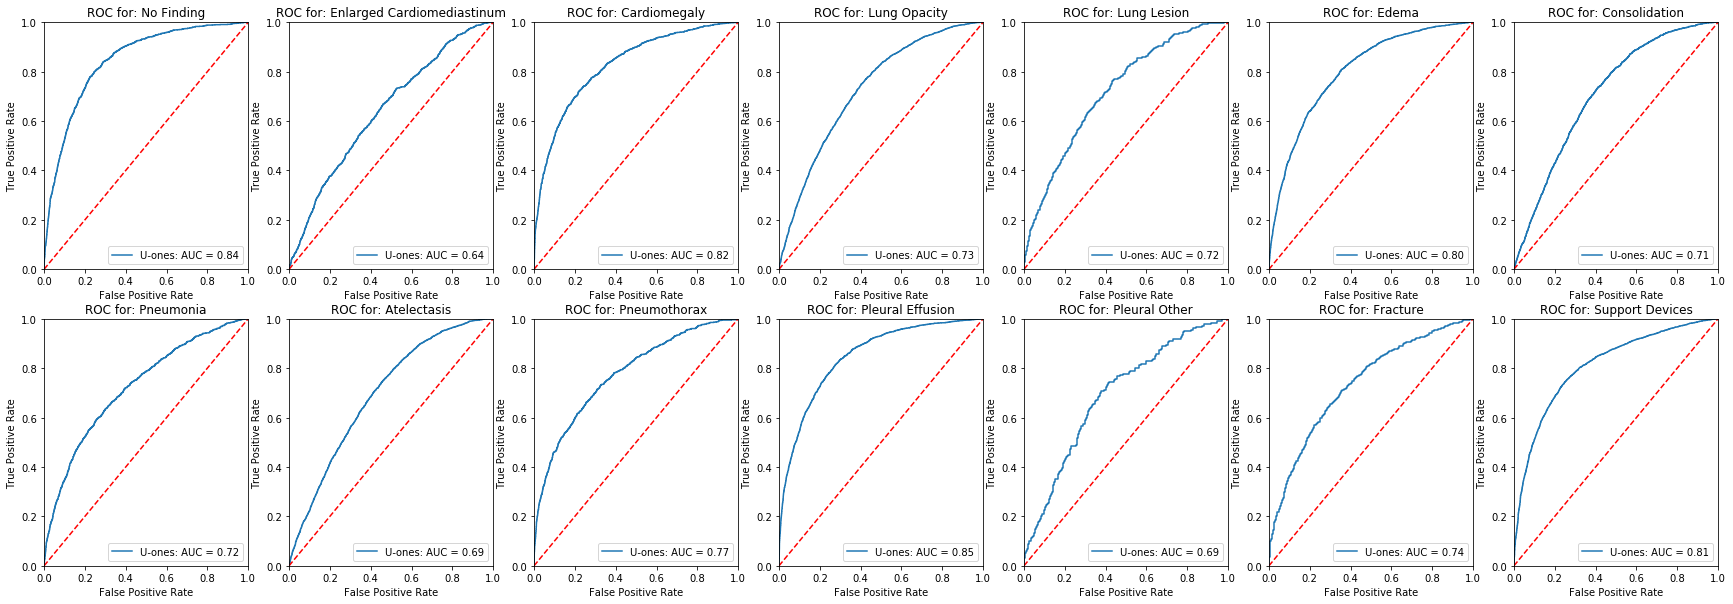

In [22]:
avg = []
plt.figure(figsize = (30,10))
for z in range(14):
    fpr, tpr, threshold = metrics.roc_curve(y_true[:,z], y_preds1[:,z])
    roc_auc = metrics.auc(fpr, tpr)
    avg.append(roc_auc)
    f = plt.subplot(2, 7, z+1)
    #plt.figure()
    plt.title('ROC for: ' + list(dtr.columns[1:])[z])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


print(sum(avg)/len(avg))

In [23]:
test_generator.reset()
pred= model_2.predict_generator(test_generator, steps=test_generator.n//test_generator.batch_size)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:])))

                            precision    recall  f1-score   support

                No Finding       0.55      0.12      0.20      1280
Enlarged Cardiomediastinum       0.00      0.00      0.00      1052
              Cardiomegaly       0.65      0.17      0.27      1381
              Lung Opacity       0.64      0.56      0.60      4755
               Lung Lesion       0.00      0.00      0.00       444
                     Edema       0.72      0.17      0.27      2895
             Consolidation       0.00      0.00      0.00      1844
                 Pneumonia       0.00      0.00      0.00      1082
               Atelectasis       0.51      0.39      0.44      3421
              Pneumothorax       0.58      0.01      0.02       727
          Pleural Effusion       0.62      0.78      0.69      3492
             Pleural Other       0.00      0.00      0.00       180
                  Fracture       0.00      0.00      0.00       485
           Support Devices       0.70      0.71

C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
y_preds2 = np.array(pred)

0.7187779871864646


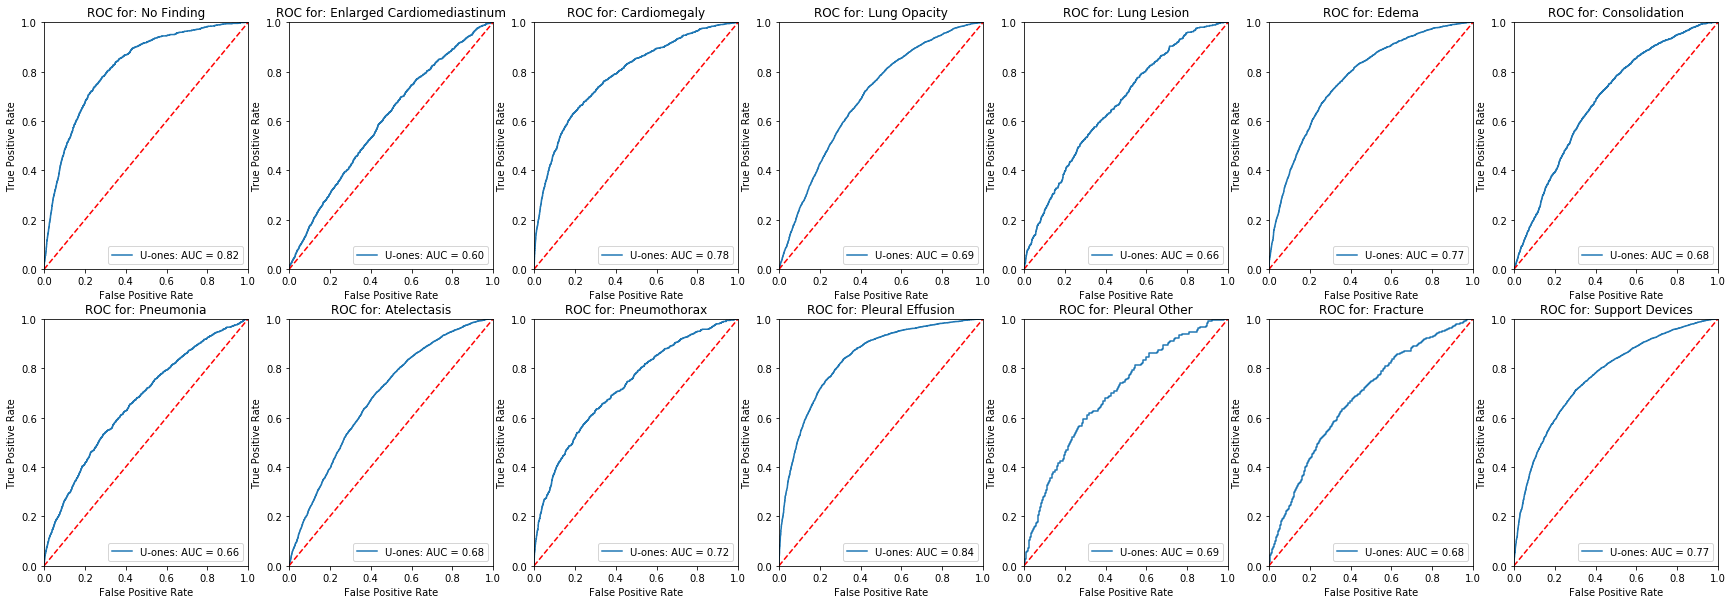

In [25]:
avg = []
plt.figure(figsize = (30,10))
for z in range(14):
    fpr, tpr, threshold = metrics.roc_curve(y_true[:,z], y_preds2[:,z])
    roc_auc = metrics.auc(fpr, tpr)
    avg.append(roc_auc)
    f = plt.subplot(2, 7, z+1)
    #plt.figure()
    plt.title('ROC for: ' + list(dtr.columns[1:])[z])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


print(sum(avg)/len(avg))

In [26]:
test_generator.reset()
pred= model_3.predict_generator(test_generator, steps=test_generator.n//test_generator.batch_size)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:])))

                            precision    recall  f1-score   support

                No Finding       0.48      0.38      0.43      1280
Enlarged Cardiomediastinum       0.00      0.00      0.00      1052
              Cardiomegaly       0.44      0.42      0.43      1381
              Lung Opacity       0.63      0.67      0.65      4755
               Lung Lesion       0.00      0.00      0.00       444
                     Edema       0.70      0.22      0.33      2895
             Consolidation       0.00      0.00      0.00      1844
                 Pneumonia       0.80      0.01      0.01      1082
               Atelectasis       0.53      0.36      0.43      3421
              Pneumothorax       0.55      0.04      0.07       727
          Pleural Effusion       0.65      0.75      0.69      3492
             Pleural Other       0.00      0.00      0.00       180
                  Fracture       0.00      0.00      0.00       485
           Support Devices       0.64      0.88

C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
y_preds3 = np.array(pred)

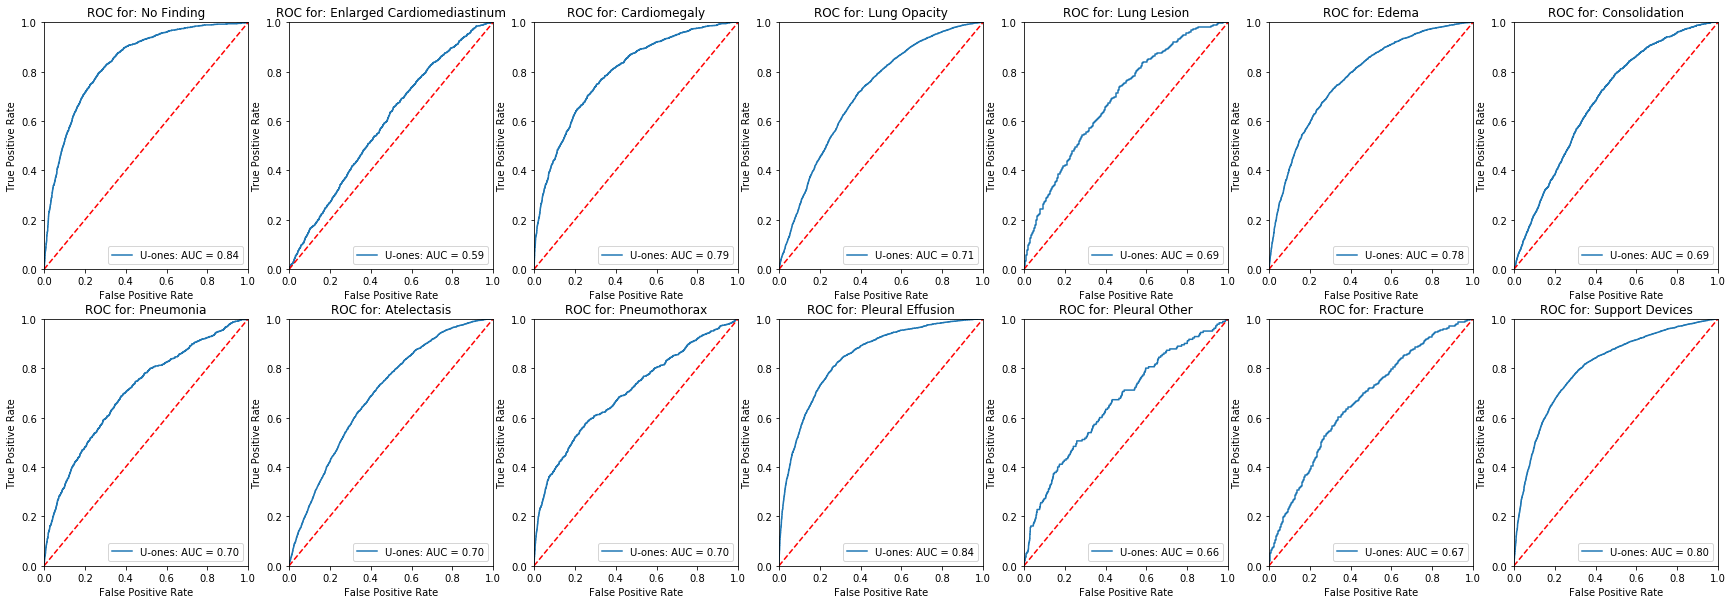

In [28]:
plt.figure(figsize = (30,10))
for z in range(14):
    fpr, tpr, threshold = metrics.roc_curve(y_true[:,z], y_preds3[:,z])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, z+1)
    #plt.figure()
    plt.title('ROC for: ' + list(dtr.columns[1:])[z])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


In [69]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
res = np.sum(np.array([y_preds1, y_preds2, y_preds3]), axis=0) / 3

In [48]:
res = np.zeros((y_preds1.shape[0],y_preds1.shape[1]))
for i in range(y_preds1.shape[0]):
    for j in range(y_preds1.shape[1]):
        if len(np.where(np.array([y_preds1[i,j],y_preds2[i,j], y_preds3[i,j]]) > 0.5)[0]) >= 2:
            res[i,j] = [y_preds1[i,j],y_preds2[i,j], y_preds3[i,j]][max(np.where(np.array([y_preds1[i,j],y_preds2[i,j], y_preds3[i,j]]) > 0.5)[0])]
        else:
            res[i,j] = [y_preds1[i,j],y_preds2[i,j], y_preds3[i,j]][min(np.where(np.array([y_preds1[i,j],y_preds2[i,j], y_preds3[i,j]]) < 0.5)[0])]

0.7543060259401309


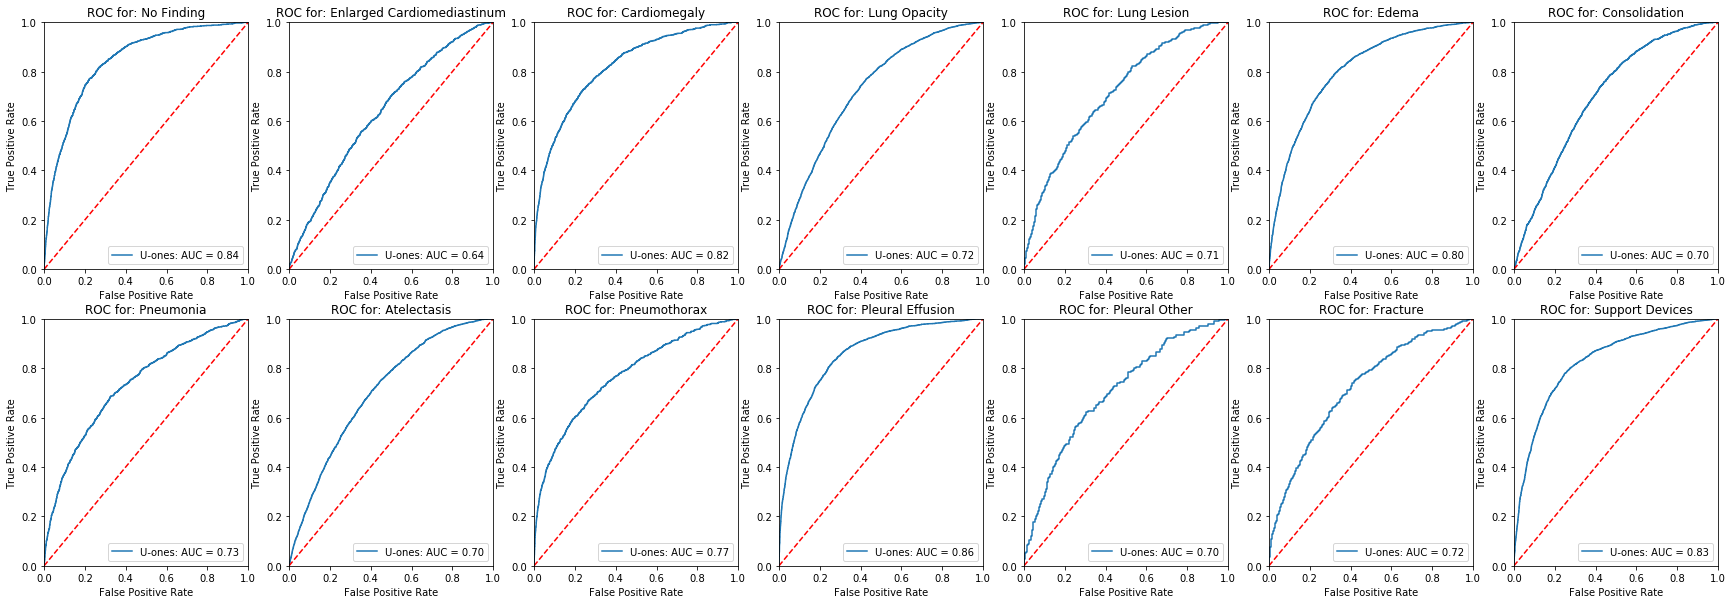

In [30]:
avg = []
plt.figure(figsize = (30,10))
for z in range(14):
    fpr, tpr, threshold = metrics.roc_curve(y_true[:,z], res[:,z])
    roc_auc = metrics.auc(fpr, tpr)
    avg.append(roc_auc)
    f = plt.subplot(2, 7, z+1)
    #plt.figure()
    plt.title('ROC for: ' + list(dtr.columns[1:])[z])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

print(sum(avg)/len(avg))

0.7456589695925968


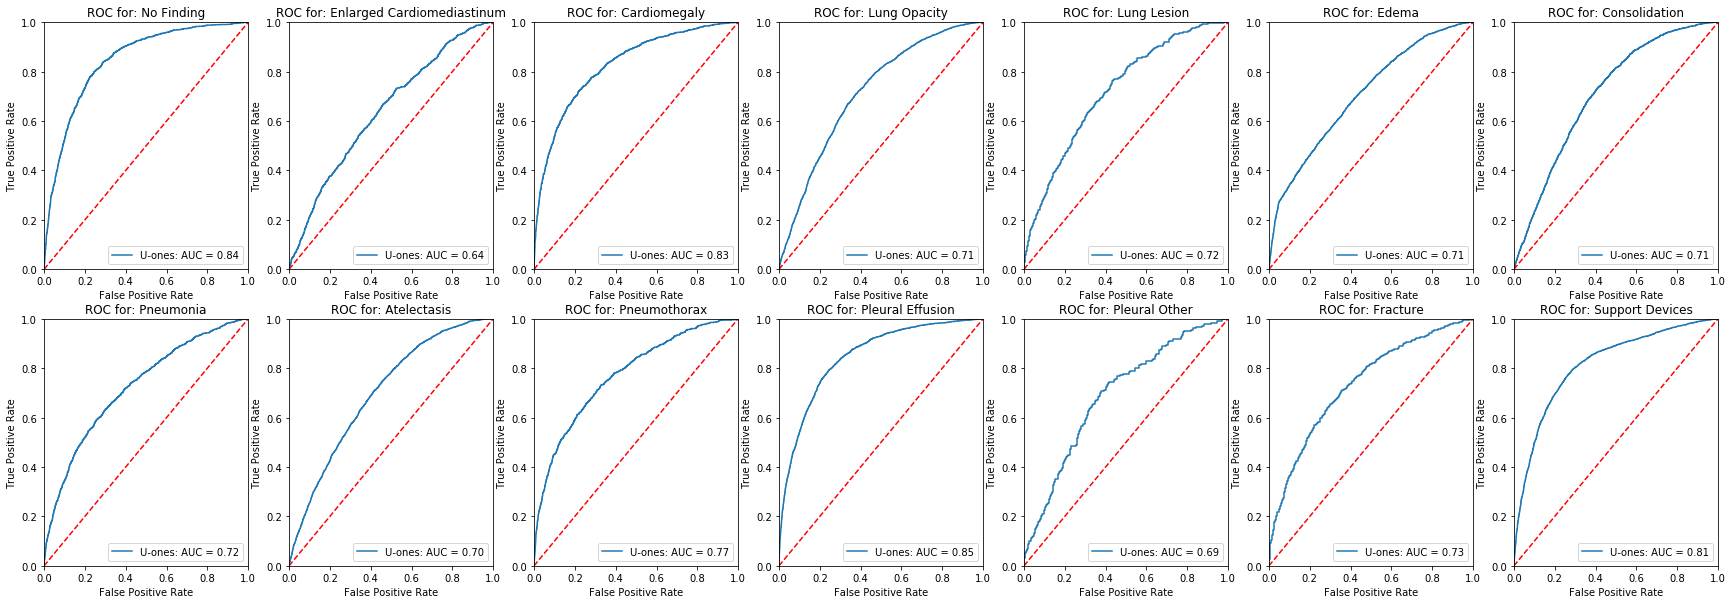

In [49]:
avg = []
plt.figure(figsize = (30,10))
for z in range(14):
    fpr, tpr, threshold = metrics.roc_curve(y_true[:,z], res[:,z])
    roc_auc = metrics.auc(fpr, tpr)
    avg.append(roc_auc)
    f = plt.subplot(2, 7, z+1)
    #plt.figure()
    plt.title('ROC for: ' + list(dtr.columns[1:])[z])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

print(sum(avg)/len(avg))

0.7544525430588284


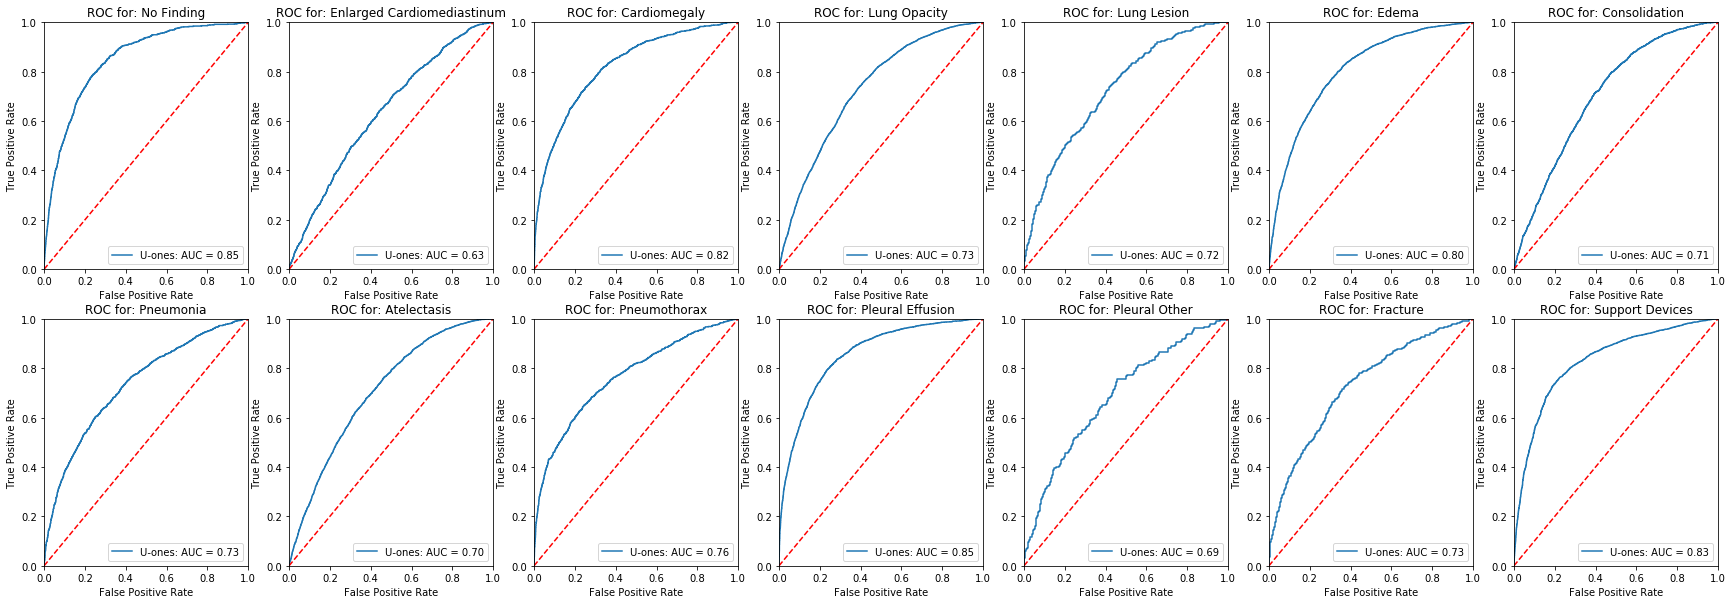

In [51]:
avg = []
plt.figure(figsize = (30,10))
for z in range(14):
    fpr, tpr, threshold = metrics.roc_curve(y_true[:,z], res[:,z])
    roc_auc = metrics.auc(fpr, tpr)
    avg.append(roc_auc)
    f = plt.subplot(2, 7, z+1)
    #plt.figure()
    plt.title('ROC for: ' + list(dtr.columns[1:])[z])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

print(sum(avg)/len(avg))